In [1]:
import lsdb
import numpy as np
import nested_pandas as npd
import astropy.units as u
from astropy.coordinates import SkyCoord

# `Catalog.from_flat` Development

In [2]:
# Generate Original Catalog
#cat = lsdb.generate_catalog(5000,200, lowest_order=3,ra_range=(15.0,25.0), dec_range=(34.0,44.0))
cat = lsdb.generate_catalog(5000,100, lowest_order=4, ra_range=(15.0,25.0), dec_range=(34.0,44.0), seed=1)

# Explode to flat
def explode_nested(partition):
    return partition.explode("nested")
exploded_cat = cat.map_partitions(explode_nested)

# Jitter RA to simulate different healpix ids
flat_nf = exploded_cat.compute().reset_index().drop(columns="_healpix_29")
def jitter_ra(row):
    return row["ra"]+(np.random.random()*0.02)
flat_nf["ra"] = flat_nf.map_rows(jitter_ra, output_names="new_ra")["new_ra"]

# Load flat nf into LSDB
flat_cat = lsdb.from_dataframe(flat_nf, lowest_order=3)
flat_nf = flat_cat.compute()

In [3]:
cat.head(3)

ra        dec     id         a         b  \
_healpix_29                                                           
157594065296659945  16.441596  34.845603  25520  0.000114  0.064453   
157605255620332004   16.60652  35.088294    863   0.16983  0.943041   
157572387917291825  16.916163  34.820524  21096  0.211628  0.764995   

                                                               nested  
_healpix_29                                                            
157594065296659945  [{t: 14.707558, flux: 11.333549, band: 'r', fl...  
157605255620332004  [{t: 1.130387, flux: 57.82453, band: 'g', flux...  
157572387917291825  [{t: 15.523198, flux: 96.810427, band: 'r', fl...

## Simple Case: Identical spatial coordinates/healpix_29

In [4]:
exploded_cat.head(5)

,ra,dec,id,a,b,t,flux,band,flux_err
_healpix_29,,,,,,,,,
157594065296659945,16.441596,34.845603,25520,0.000114,0.064453,14.707558,11.333549,r,0.566677
157594065296659945,16.441596,34.845603,25520,0.000114,0.064453,10.554962,47.63856,g,2.381928
157594065296659945,16.441596,34.845603,25520,0.000114,0.064453,17.577735,65.783219,g,3.289161
157594065296659945,16.441596,34.845603,25520,0.000114,0.064453,13.17778,21.069909,r,1.053495
157594065296659945,16.441596,34.845603,25520,0.000114,0.064453,16.706805,18.83848,r,0.941924


In [5]:
ident_cat = lsdb.Catalog.from_flat(exploded_cat,
                       base_columns=["ra","dec", "id", "a", "b"],
                       nested_columns=["t","flux", "band", "flux_err"],
                       on=None)
ident_cat.head(3)

ra        dec     id         a         b  \
_healpix_29                                                           
157594065296659945  16.441596  34.845603  25520  0.000114  0.064453   
157605255620332004   16.60652  35.088294    863   0.16983  0.943041   
157572387917291825  16.916163  34.820524  21096  0.211628  0.764995   

                                                               nested  
_healpix_29                                                            
157594065296659945  [{t: 14.707558, flux: 11.333549, band: 'r', fl...  
157605255620332004  [{t: 1.130387, flux: 57.82453, band: 'g', flux...  
157572387917291825  [{t: 15.523198, flux: 96.810427, band: 'r', fl...

## Harder Case: Jittered spatial coordinates/different _healpix_29

In [6]:
flat_nf

,ra,dec,id,a,b,t,flux,band,flux_err
_healpix_29,,,,,,,,,
157594063950273324,16.450194,34.845603,25520,0.000114,0.064453,14.707558,11.333549,r,0.566677
157594789384791781,16.45729,34.845603,25520,0.000114,0.064453,10.554962,47.63856,g,2.381928
...,...,...,...,...,...,...,...,...,...
198186854307986886,22.378855,42.656451,40857,0.489336,0.886007,14.245045,44.857299,r,2.242865
198186853867951114,22.375774,42.656451,40857,0.489336,0.886007,14.965847,47.432483,g,2.371624


In [ ]:
packed_cat = lsdb.Catalog.from_flat(flat_cat,
                       base_columns=["ra","dec", "id", "a", "b"],
                       nested_columns=["t","flux", "band", "flux_err"],
                       on="id",)
packed_cat.head(5)

id         ra        dec         a         b  \
_healpix_29                                                           
157594063531105321  25520  16.450194  34.845603  0.000114  0.064453   
157605164285101695    863  16.608454  35.088294   0.16983  0.943041   
157570916275228972  21096  16.934836  34.820524  0.211628  0.764995   
157604647370659191  49093  16.505387   35.05286  0.903402  1.597502   
157570759497743829   7658  16.977302  34.794926  0.929437  1.128143   

                                                               nested  
_healpix_29                                                            
157594063531105321  [{t: 14.707558, flux: 11.333549, band: 'r', fl...  
157605164285101695  [{t: 1.130387, flux: 57.82453, band: 'g', flux...  
157570916275228972  [{t: 15.523198, flux: 96.810427, band: 'r', fl...  
157604647370659191  [{t: 9.093251, flux: 9.430408, band: 'g', flux...  
157570759497743829  [{t: 10.427052, flux: 43.988591, band: 'g', fl...

In [ ]:
# Within a single partition, we've lost data
from nested_pandas.utils import count_nested
count_nested(packed_cat.partitions[1].compute(), "nested").query("n_nested<100").head(5)

id         ra        dec         a         b  \
_healpix_29                                                           
160617392888528522  48362   17.14393  35.415137  0.799615  0.568051   
160452319712409940  38518  17.955441  34.566313  0.622313  0.300302   
160062542807022876  29931  18.437053  34.069202  0.286984   1.40924   
161951422215046841  17788   23.65992  40.502009   0.69627  0.574439   
161944309749179360  44138  23.771462   40.36723  0.066571  1.088315   

                                                               nested  \
_healpix_29                                                             
160617392888528522  [{t: 17.694997, flux: 64.077344, band: 'r', fl...   
160452319712409940  [{t: 18.663302, flux: 33.369346, band: 'g', fl...   
160062542807022876  [{t: 16.185852, flux: 87.223655, band: 'r', fl...   
161951422215046841  [{t: 17.848518, flux: 63.83419, band: 'r', flu...   
161944309749179360  [{t: 6.110959, flux: 94.202341, band: 'r', flu...   

                    n_nested  
_healpix_29                   
160617392888528522        86  
160452319712409940        63  
160062542807022876        75  
161951422215046841        40  
161944309749179360        87

## Current Recourse: Working In-Memory

In [9]:
# If the total data size is small enough, users can always do this in-memory
packed_nf = npd.NestedFrame.from_flat(flat_cat.compute(),
                       base_columns=["ra","dec", "id", "a", "b"],
                       nested_columns=["t","flux", "band", "flux_err"],
                       on="id",)
packed_nf

ra        dec         a         b  \
id                                                
25520  16.450194  34.845603  0.000114  0.064453   
863    16.608454  35.088294   0.16983  0.943041   
...          ...        ...       ...       ...   
19153  21.855408  43.954567  0.908171  0.640171   
40857  22.383897  42.656451  0.489336  0.886007   

                                                  nested  
id                                                        
25520  [{t: 14.707558, flux: 11.333549, band: 'r', fl...  
863    [{t: 1.130387, flux: 57.82453, band: 'g', flux...  
...                                                  ...  
19153  [{t: 8.775387, flux: 31.74458, band: 'g', flux...  
40857  [{t: 4.70206, flux: 15.808155, band: 'g', flux...  

[5000 rows x 5 columns]

## Another Potential Option: Making an Object Table

In [16]:
def make_object_table(nf):
    obj_table = nf[["id","ra","dec","a","b"]].drop_duplicates(subset="id")
    return obj_table

# drop duplicates is completely handling the surviving ra/dec values here
# could easily compute an average ra/dec if desired
obj_cat = flat_cat.map_partitions(make_object_table)
obj_cat.compute()

,id,ra,dec,a,b
_healpix_29,,,,,
157594063950273324,25520,16.450194,34.845603,0.000114,0.064453
157605256262780607,863,16.608454,35.088294,0.16983,0.943041
...,...,...,...,...,...
198388084701774335,19153,21.855408,43.954567,0.908171,0.640171
198186855565320886,40857,22.383897,42.656451,0.489336,0.886007


In [25]:
packed_by_join = obj_cat.join_nested(flat_cat[["id", "t","flux", "band", "flux_err"]], 
                                     left_on="id",
                                     right_on="id",
                                     nested_column_name="nested")
packed_by_join.head(5)

/Users/dbranton/lincc/lsdb/src/lsdb/dask/join_catalog_data.py:476: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


id         ra        dec         a         b  \
_healpix_29                                                           
157594063950273324  25520  16.450194  34.845603  0.000114  0.064453   
157605256262780607    863  16.608454  35.088294   0.16983  0.943041   
157570916469919026  21096  16.934836  34.820524  0.211628  0.764995   
157604671613671099  49093  16.505387   35.05286  0.903402  1.597502   
157570760577161257   7658  16.977302  34.794926  0.929437  1.128143   

                                                               nested  
_healpix_29                                                            
157594063950273324  [{t: 14.707558, flux: 11.333549, band: 'r', fl...  
157605256262780607  [{t: 1.130387, flux: 57.82453, band: 'g', flux...  
157570916469919026  [{t: 15.523198, flux: 96.810427, band: 'r', fl...  
157604671613671099  [{t: 9.093251, flux: 9.430408, band: 'g', flux...  
157570760577161257  [{t: 10.427052, flux: 43.988591, band: 'g', fl...

In [ ]:
# We still lose data
from nested_pandas.utils import count_nested
count_nested(packed_by_join.partitions[1].compute(), "nested").query("n_nested<100").head(5)

id         ra        dec         a         b  \
_healpix_29                                                           
160617392993324422  48362   17.14393  35.415137  0.799615  0.568051   
160452326779241832  38518  17.955441  34.566313  0.622313  0.300302   
160062549959446064  29931  18.437053  34.069202  0.286984   1.40924   
161951422576801226  17788   23.65992  40.502009   0.69627  0.574439   
161944316886127735  44138  23.771462   40.36723  0.066571  1.088315   

                                                               nested  \
_healpix_29                                                             
160617392993324422  [{t: 17.694997, flux: 64.077344, band: 'r', fl...   
160452326779241832  [{t: 18.663302, flux: 33.369346, band: 'g', fl...   
160062549959446064  [{t: 16.185852, flux: 87.223655, band: 'r', fl...   
161951422576801226  [{t: 17.848518, flux: 63.83419, band: 'r', flu...   
161944316886127735  [{t: 6.110959, flux: 94.202341, band: 'r', flu...   

                    n_nested  
_healpix_29                   
160617392993324422        86  
160452326779241832        63  
160062549959446064        75  
161951422576801226        40  
161944316886127735        87

In [ ]:
#crossmatch_nested?
# this simulated dataset may not be a good fit at all, but data loss issues will be present here in all likelihood

packed_cat_crossmatched = obj_cat.crossmatch_nested(other=flat_cat[["id", "ra","dec", "t","flux", "band", "flux_err"]],
                                                    n_neighbors=100,)
packed_cat_crossmatched.head(5)

/Users/dbranton/lincc/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:397: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


id         ra        dec         a         b  \
_healpix_29                                                           
157594063950273324  25520  16.450194  34.845603  0.000114  0.064453   
157605256262780607    863  16.608454  35.088294   0.16983  0.943041   
157570916469919026  21096  16.934836  34.820524  0.211628  0.764995   
157604671613671099  49093  16.505387   35.05286  0.903402  1.597502   
157570760577161257   7658  16.977302  34.794926  0.929437  1.128143   

                                                  from_lsdb_dataframe  
_healpix_29                                                            
157594063950273324  [{id: 25520, ra: 16.450194, dec: 34.845603, t:...  
157605256262780607  [{id: 863, ra: 16.608454, dec: 35.088294, t: 1...  
157570916469919026  [{id: 21096, ra: 16.934836, dec: 34.820524, t:...  
157604671613671099  [{id: 49093, ra: 16.505387, dec: 35.05286, t: ...  
157570760577161257  [{id: 7658, ra: 16.977302, dec: 34.794926, t: ...

## Messing around with Margins

(<Figure size 1000x500 with 3 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - from_lsdb_dataframe_5.0arcs'}>)

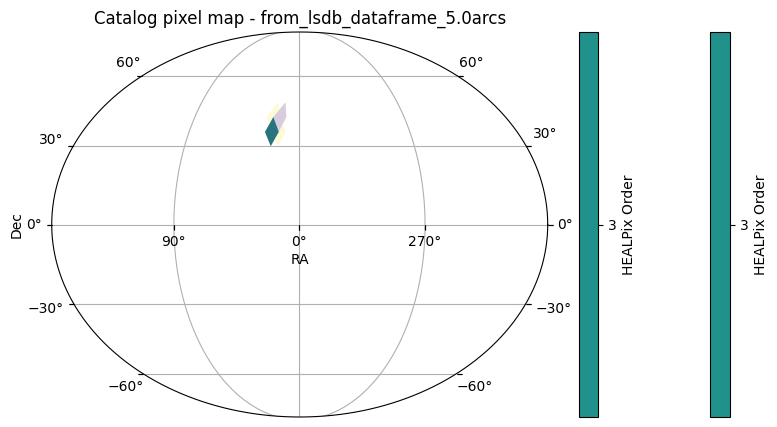

In [18]:
flat_cat.partitions[1].plot_pixels()
flat_cat.margin.partitions[1].plot_pixels(alpha=0.2)

(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the from_lsdb_dataframe_5.0arcs catalog'}>)

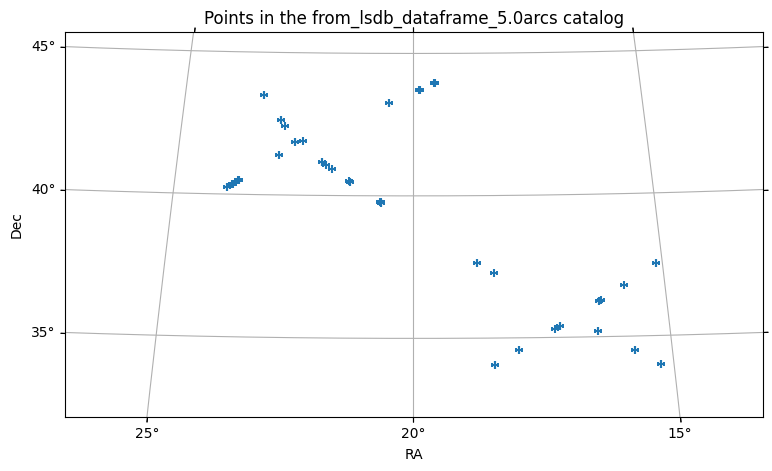

In [19]:
packed_cat.margin.plot_points(fov=(10 * u.deg, 15 * u.deg), center=SkyCoord(20.0, 39.0, unit="deg"),marker="+")

(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the from_lsdb_dataframe_5.0arcs catalog'}>)

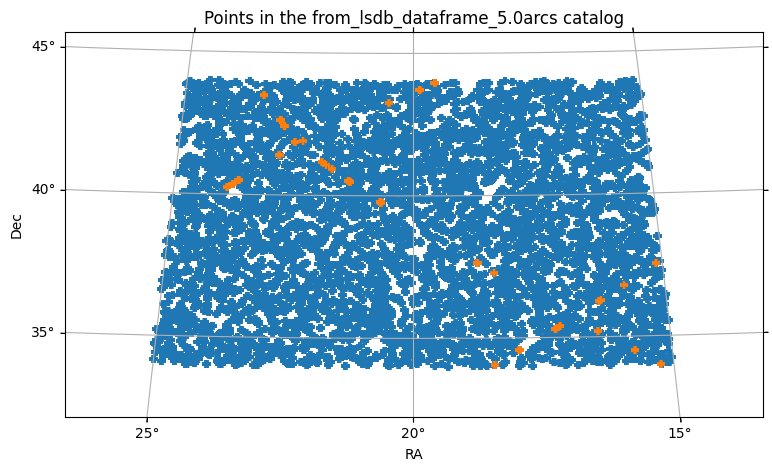

In [20]:
import astropy.units as u
from astropy.coordinates import SkyCoord
flat_cat.plot_points(fov=(10 * u.deg, 15 * u.deg), center=SkyCoord(20.0, 39.0, unit="deg"),marker="+")
flat_cat.margin.plot_points(fov=(10 * u.deg, 15 * u.deg), center=SkyCoord(20.0, 39.0, unit="deg"),marker="+")

In [21]:
# Input to from_flat should always be a catalog, but we'll operate through map_partitions (nestedframe)

# If we treat _healpix_29 as a base column, it will just choose the first(?) one to use
#npd.NestedFrame.from_flat(flat_nf.reset_index(),
#                          base_columns=["_healpix_29", "ra","dec", "id", "a", "b"],
#                          nested_columns=["t","flux", "band", "flux_err"],
#                          on="id")

# If we treat it as nested column, we have control over what _healpix_29 value is assigned
packed_nf = npd.NestedFrame.from_flat(flat_nf.reset_index(),
                                      base_columns=["ra","dec", "id", "a", "b"],
                                      nested_columns=["_healpix_29","t","flux", "band", "flux_err"],
                                      on="id")
# Select minimum healpix_29 and use as new index
packed_nf["_healpix_29"] = packed_nf.map_rows(np.min, columns="nested._healpix_29", row_container="args")[0]
packed_nf = packed_nf.drop(["nested._healpix_29"], axis=1).set_index("_healpix_29")
packed_nf



ra        dec         a         b  \
_healpix_29                                                    
157594058162137879   16.44639  34.845603  0.000114  0.064453   
157605164284842024  16.620948  35.088294   0.16983  0.943041   
...                       ...        ...       ...       ...   
198388072538030927  21.858534  43.954567  0.908171  0.640171   
198186848497918393  22.369485  42.656451  0.489336  0.886007   

                                                               nested  
_healpix_29                                                            
157594058162137879  [{t: 14.707558, flux: 11.333549, band: 'r', fl...  
157605164284842024  [{t: 1.130387, flux: 57.82453, band: 'g', flux...  
...                                                               ...  
198388072538030927  [{t: 8.775387, flux: 31.74458, band: 'g', flux...  
198186848497918393  [{t: 4.70206, flux: 15.808155, band: 'g', flux...  

[5000 rows x 5 columns]